In [1]:
import os
import sys
root_dir = os.path.abspath('../')
sys.path.append(root_dir)

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- Stunning palette: Viridis or Plasma ---
palette = sns.color_palette("viridis", 8)

sns.set_theme(
    style="whitegrid",
    font="sans-serif",
    rc={
        "font.size": 13,
        "axes.titlesize": 16,
        "axes.titleweight": "bold",
        "axes.labelsize": 13,
        "axes.labelweight": "semibold",
        "axes.edgecolor": "#2F2F2F",
        "axes.linewidth": 0.8,
        "grid.color": "#CCCCCC",
        "grid.linewidth": 0.6,
        "grid.alpha": 0.35,
        "figure.facecolor": "#FAFAFA",
        "axes.facecolor": "#FFFFFF",
        "axes.prop_cycle": plt.cycler("color", palette),
    }
)

### Nonlinear modeling

x_t  ──►  Encoder ──►  z_t  ──►  VAR ──►  z_{t+h}  ──►  SupplyHead ──►  y_{t+h}

* x_t: Our features (demographic + date element + KCD codes)
* (Auto)Encoder: Latent factors (non linear)
  - Shape: x_t - hidden encoding - z_t - hidden decoding - x_t
* z_t: Latent factors. VAR to predict z_{t+h}
* z_t is used to SupplyHead

In [2]:
from pipeline.lavar.config import LAVARConfig
from pipeline.lavar.dataset import RollingXYDataset
from pipeline.lavar.scalers import StandardScalerTorch
from pipeline.lavar.models import LAVAR, LAVARWithSupply
from pipeline.lavar.train_stage1 import stage1_train_lavar
from pipeline.lavar.train_stage2 import stage2_train_supply

import torch
from torch.utils.data import DataLoader

In [3]:
# Engineered data
lavar_data1 = pd.read_parquet(
    os.path.join(root_dir, "data/processed/hana_ent/lavar_daily1.parquet")
)  # demographics, diagnosis code

lavar_data2 = pd.read_parquet(
    os.path.join(root_dir, "data/processed/hana_ent/lavar_daily2.parquet")
)  # demographics, ATC code

# Resample, daily-wise
full_range = pd.date_range(lavar_data1.index.min(), lavar_data1.index.max(), freq='D')
lavar_data1 = lavar_data1.reindex(full_range)
lavar_data2 = lavar_data2.reindex(full_range)

lavar_data1 = lavar_data1.fillna(0)
lavar_data2 = lavar_data2.fillna(0)

common = [i for i in lavar_data1.columns if i in lavar_data2.columns]
col1 = [i for i in lavar_data1.columns if i not in common]
col2 = [i for i in lavar_data2.columns if i not in common]

non_supply_df = lavar_data1[common + col1]
non_supply_cols = common + col1
supply_df = lavar_data2[col2]
supply_cols = col2

X = torch.tensor(non_supply_df.values, dtype=torch.float32)  # (T, Dx)
y = torch.tensor(supply_df.values, dtype=torch.float32)      # (T, Dy)

# (torch.Size([2556, 40]), torch.Size([2556, 36]))
# T = 2556, Dx = 40, Dy = 36
X.shape, y.shape  

(torch.Size([2556, 40]), torch.Size([2556, 36]))

In [30]:
cfg = LAVARConfig()

T = X.shape[0]
min_train = cfg.train_days
H = cfg.horizon
step = 7

print("Total samples: ", T)
print("Training samples: ", min_train)  # 3 years
print("Horizon: ", H)  # 14 days
print("Step: ", step)  # 7 days, Weekly rolling

fold_ends = []
t = min_train
while t + H <= T:
    fold_ends.append(t)
    t += step

all_fold_errors = []
all_pred_times, all_pred_values, all_true_values = [], [], []
for fold_id, t_end in enumerate(fold_ends, start=1):
    print(f"\n=== Fold {fold_id} | train until day {t_end} ===")
    X_train_raw = X[:t_end]
    y_train_raw = y[:t_end]

    # give buffer so rolling windows are valid
    X_val_raw = X[t_end - (cfg.p + cfg.horizon) : t_end + cfg.horizon]
    y_val_raw = y[t_end - (cfg.p + cfg.horizon) : t_end + cfg.horizon]

    x_scaler = StandardScalerTorch().fit(X_train_raw)
    X_train = x_scaler.transform(X_train_raw)
    X_val = x_scaler.transform(X_val_raw)

    if cfg.supply_loss == "mse":
        y_scaler = StandardScalerTorch().fit(y_train_raw)
        y_train = y_scaler.transform(y_train_raw)
        y_val = y_scaler.transform(y_val_raw)
    else:
        y_train = y_train_raw
        y_val = y_val_raw

    train_ds = RollingXYDataset(x=X_train, y=y_train, p=cfg.p, horizon=cfg.horizon)
    val_ds = RollingXYDataset(x=X_val, y=y_val, p=cfg.p, horizon=cfg.horizon)
    
    train_loader = DataLoader(train_ds, batch_size=cfg.batch_size, shuffle=True, num_workers=cfg.num_workers)
    val_loader = DataLoader(val_ds, batch_size=cfg.batch_size, shuffle=False, num_workers=cfg.num_workers)

    lavar = LAVAR(
        input_dim=X_train.shape[1],
        latent_dim=cfg.latent_dim,
        transition_order=cfg.p,
        encoder_hidden_dims=cfg.encoder_hidden,
        decoder_hidden_dims=cfg.decoder_hidden,
    ).to(cfg.device)

    stage1_train_lavar(
        model=lavar,
        train_loader=train_loader,
        val_loader=val_loader,
        cfg=cfg,
    )

    model = LAVARWithSupply(
        lavar=lavar,
        supply_dim=y_train.shape[1],
        horizon=cfg.horizon,
    ).to(cfg.device)
    
    stage2_train_supply(
        model=model,
        train_loader=train_loader,
        val_loader=val_loader,
        cfg=cfg,
    )

    model.eval()
    with torch.no_grad():
        x_recent_raw = X[t_end - cfg.p : t_end]
        x_recent = x_scaler.transform(x_recent_raw)
        
        # Predict
        y_hat = model(x_recent.unsqueeze(0)).squeeze(0)  # (H, Dy)

        if cfg.supply_loss == "mse":
            y_hat = y_scaler.inverse_transform(y_hat)

        y_true = y[t_end : t_end + cfg.horizon]  # (H, Dy)

        # Store predictions
        times = np.arange(t_end, t_end + cfg.horizon)
        all_pred_times.append(times)
        all_pred_values.append(y_hat.detach().cpu().numpy())
        all_true_values.append(y_true.detach().cpu().numpy())

        # Store error
        fold_mse = torch.mean((y_hat - y_true) ** 2).item()
        all_fold_errors.append(fold_mse)

    print(f"Fold {fold_id} MSE = {fold_mse:.4f}")


print("Rolling MSE:")
print("mean :", np.mean(all_fold_errors))
print("std  :", np.std(all_fold_errors))


Total samples:  2556
Training samples:  1095
Horizon:  14
Step:  7

=== Fold 1 | train until day 1095 ===
Epoch 1: New best validation loss 2.473631
Loaded best model from epoch 1, best validation loss 2.473631
Epoch 2: New best validation loss 2.454121
Loaded best model from epoch 2, best validation loss 2.454121
Epoch 3: New best validation loss 2.447793
Loaded best model from epoch 3, best validation loss 2.447793
Epoch 4: New best validation loss 2.444764
Loaded best model from epoch 4, best validation loss 2.444764
Epoch 5: New best validation loss 2.441079
Loaded best model from epoch 5, best validation loss 2.441079
Epoch 6: New best validation loss 2.429026
Loaded best model from epoch 6, best validation loss 2.429026
Epoch 7: New best validation loss 2.399743
Loaded best model from epoch 7, best validation loss 2.399743
Epoch 8: New best validation loss 2.364377
Loaded best model from epoch 8, best validation loss 2.364377
Epoch 9: New best validation loss 2.346274
Loaded best

In [60]:
supply_df.columns[15]

'H02AB'

In [62]:
supply_df.sum().sort_values(ascending=False)

H02AB    94013.0
J01GB    68885.0
N02AX    52883.0
B05BB    38936.0
M01AB    36480.0
J01DC    35753.0
N01BB    20534.0
R06AB    11221.0
A03FA     1987.0
B05XA     1583.0
D11AH     1275.0
J01CR     1124.0
A11EA      985.0
N05BA      745.0
J01MA      581.0
N01AX      337.0
N05CD      335.0
B02AA      278.0
A02BA      238.0
R05CB      200.0
A03AB      185.0
N01AH      154.0
A04AA      142.0
C01EA       75.0
M03AC       66.0
N07AA       65.0
N02AB       49.0
M03AB       48.0
J01DD       31.0
R03CA       25.0
C08CA       10.0
C07AG        9.0
A10AE        3.0
V03AB        3.0
B05BA        1.0
A10AB        1.0
dtype: float64

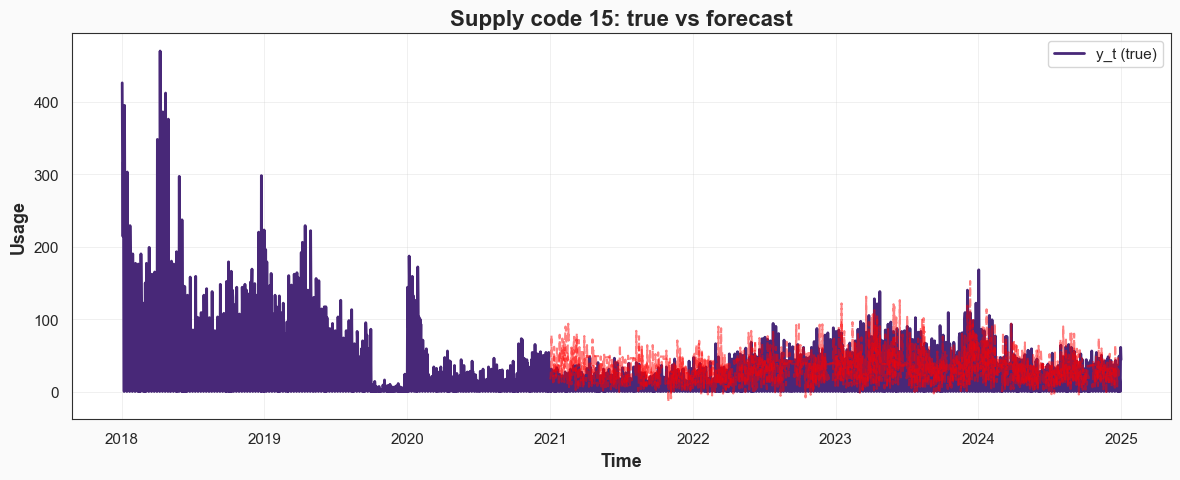

In [67]:
j = 15

dates = non_supply_df.index  # pandas DatetimeIndex
plt.figure(figsize=(12, 5))
plt.plot(dates, y[:, j].cpu().numpy(), label="y_t (true)", linewidth=2)

for t, yhat in zip(all_pred_times, all_pred_values):
    plt.plot(
        dates[t],
        yhat[:, j],
        linestyle="--",
        # marker="*",
        color="red",
        alpha=0.5,
    )

plt.title(f"Supply code {j}: true vs forecast")
plt.xlabel("Time")
plt.ylabel("Usage")
plt.legend()
plt.tight_layout()
plt.show()